In [2]:
import datetime
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from ipywidgets import widgets
import plotly.express as px 
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from numpy import fft
import scipy
import pylab as py
from skimage import util

In [3]:
df_pp = pd.read_csv('/home/deaddemocracy/Documents/Major_Project/Extract_Feb18_28_1PM/sensor1_pp.csv',decimal = ',',index_col = 0)

In [4]:
df_pp.head()

,ax(g),ay(g),az(g),wx(deg/s),wy(deg/s),wz(deg/s),AngleX(deg),AngleY(deg),AngleZ(deg),T(°),hx,hy,hz
ChipTime,,,,,,,,,,,,,
2020-02-18 15:40:20.960,-0.1851,0.1094,0.9927,-5.7373,-8.0566,5.188,7.3663,11.4148,2.2852,18.11,929,-1405,27
2020-02-18 15:40:21.160,-0.1533,0.0942,1.0044,-6.1646,9.5215,0.2441,6.3062,10.0964,1.7084,18.15,924,-1399,47
2020-02-18 15:40:21.360,-0.1455,0.0859,1.0083,2.4414,1.5259,-1.0986,5.9656,9.5142,1.9391,18.14,896,-1369,51
2020-02-18 15:40:21.560,-0.1299,0.1064,1.0044,3.2959,-5.0659,9.2163,6.7072,8.4705,3.7573,18.14,931,-1369,49
2020-02-18 15:40:21.760,-0.12300000000000001,0.0986,1.0044,-4.5166,-6.5918,2.6245,6.3336,7.5751,4.5593,18.14,1012,-1426,39


In [5]:
df_pp.index = pd.to_datetime(df_pp.index)


In [6]:
N = len(df_pp['az(g)'])

In [7]:
total_seconds = ((df_pp.index.max() - df_pp.index.min()).total_seconds())
total_seconds

849657.8

In [133]:
#Sampling frequency = 1 / (difference of two consecutive timestamps in seconds)                                                        )

Fs = 1/((df_pp.index[2] - df_pp.index[1]).total_seconds())
Fs


5.0

In [134]:
T = 1 / Fs; #Sampling period 
T

0.2

# RMS Plot - Currently Unnecessary

In [39]:
new_index = pd.to_datetime(df_pp.index) #Convert DateTimeIndex type to datetime
new_index = new_index.round('1s') #Round all values to their nearest second
new_index = np.unique(new_index) # Take unique values i.e. each second timestamp
new_index = new_index[1:]
new_index = pd.to_datetime(new_index)#Convert back to DateTimeIndex


In [40]:
x = df_pp['ax(g)']

In [41]:
w = np.int(np.floor(Fs)) #width of the window for computing RMS

In [42]:
steps = np.int(np.floor(N/w)) #no of steps to calculate rms of entire signal

In [12]:
x_RMS = np.zeros((steps,1)); #arrays that store time and amplitude in RMS

In [17]:
for i in range(0,steps):
    x_RMS[i] = np.sqrt(np.mean(x[(i * w):((i +1) * w)] ** 2));

In [18]:
x_RMS = x_RMS.ravel()

In [15]:
bridge_series_rms = pd.Series(x_RMS, new_index)

In [16]:
bridge_data_rms = go.Scatter(x = bridge_series_rms.index, y = bridge_series_rms.values)

In [17]:
layout = go.Layout(title = 'RMS amplitude plot', xaxis = dict(title = 'Date'), yaxis = dict(title = 'ax(g)_RMS'))

In [18]:
fig = go.Figure(data = bridge_data_rms, layout = layout)

In [30]:
# iplot(fig)

# FFT - Caltech Tutorial


In [135]:
max_index = 2 ** (int(np.floor(np.log2(N)))) #FFT is faster for 2^N length data

In [136]:
ax_trunc = df_pp['ax(g)'].values[:max_index] # Truncated data series of length 2 ^ N 
len(ax_trunc)

131072

In [137]:
type(ax_trunc)

numpy.ndarray

In [138]:
f = np.fft.fftfreq(len(ax_trunc)) * Fs

In [139]:
psd = np.abs(np.fft.fft(ax_trunc))**2 / len(ax_trunc)


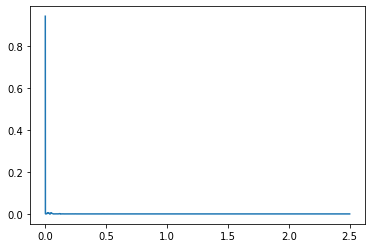

In [140]:
plt.plot(f[f>=0], psd[f>=0])

# Fast Fourier Transform with Windowing 

In [164]:
M = 1024

slices = util.view_as_windows(ax_trunc, window_shape = (M,), step=100)
print(f'ax shape: {ax_trunc.shape}, Sliced ax shape: {slices.shape}')

ax shape: (131072,), Sliced ax shape: (1301, 1024)


In [165]:
win = np.hanning(M + 1)[:-1]
slices = slices * win

In [166]:
slices = slices.T
print('Shape of slices:', slices.shape)

Shape of slices: (1024, 1301)


In [167]:
spectrum = np.fft.fft(slices, axis=0)[:M//2 +1:-1]
spectrum = np.abs(spectrum)

In [168]:
spectrum

array([[4.30651219e+00, 3.76574352e+00, 2.60590049e+00, ...,
        4.05348219e-01, 4.02082157e-01, 4.00456165e-01],
       [4.25096613e+00, 1.56491863e+00, 7.87632939e-02, ...,
        6.41514984e-03, 3.13468088e-03, 2.12996518e-03],
       [5.19016595e+00, 1.72117028e+00, 1.19360408e-01, ...,
        1.20021642e-02, 1.11362502e-02, 1.08330804e-02],
       ...,
       [1.52274100e-01, 8.73679319e-02, 1.21009227e-02, ...,
        1.80202868e-02, 1.59280463e-02, 1.21301063e-02],
       [1.80383786e-01, 7.96982348e-02, 5.65465796e-03, ...,
        1.83255106e-02, 1.23323775e-02, 4.75115892e-03],
       [2.54465002e-01, 1.03949961e-01, 2.12200938e-02, ...,
        1.72545775e-02, 1.43964041e-02, 1.18126394e-02]])

 ...]

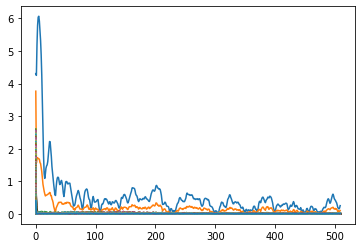

In [169]:
plt.plot(spectrum)

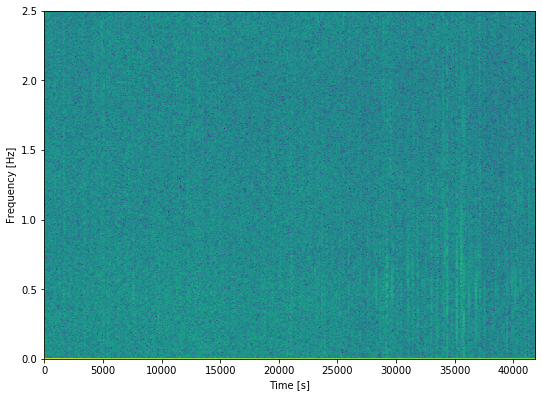

In [170]:
f, ax = plt.subplots(figsize=(8.8, 6.4))

S = np.abs(spectrum)

S = 20 * np.log10(S / np.max(S))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, total_seconds, 0, Fs / 2 ))
ax.axis('tight')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]');

# FFT - Sine Wave

In [9]:
Fs = 44100 #Sample rate
T = 1/Fs  #sampling period
t = 0.1   #seconds of sampling
N = Fs * t # total points in signal

In [11]:
#signal information 
freq = 100 #Hz
omega = 2 * np.pi * freq

In [15]:
t_vec = np.arange(N) * T #time vector

In [16]:
y = np.sin(omega * t_vec)

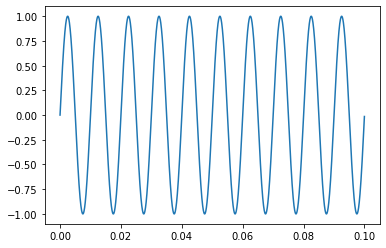

In [17]:
plt.plot(t_vec,y)
plt.show()

In [18]:
# FFT and F domain

In [19]:
Y_k = np.fft.fft(y)[0:int(N/2)]/N #FFT function numpy

In [21]:
Y_k[1:] = 2 * Y_k[1:] #take single side spectrum

In [22]:
Pxx = np.abs(Y_k)

In [23]:
f = Fs * np.arange((N/2))/N

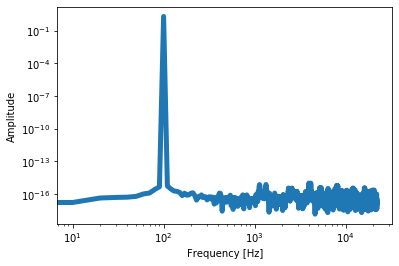

In [24]:
fig,ax = plt.subplots()
plt.plot(f,Pxx,linewidth=5)
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylabel('Amplitude')
plt.xlabel('Frequency [Hz]')
plt.show()